# Bayesian Logistic Regression with PyMC3

In this notebook we will be using pymc3 to examine posterior probability distributions for the parameters in logistic regression for classification.

We start by importing our required libraries.

In [57]:
# This is a simple example of using pymc3 for Bayesian inference of the parameter distribution.
# written by William F Basener
# University of Virginia

import pymc3 as pm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

We define a function that will be helpful for plotting.  This function does little mathematically, but will give us very nice trace plots.

In [58]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

Load the data and look a the data frame.

In [59]:
data = pd.read_csv('../input/iris-flower-dataset/IRIS.csv')
data = data[['sepal_length','sepal_width','petal_length','petal_width','species']]
print(np.unique(data['species']))
data.describe()


['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [60]:
data.loc[data['species'] == 'Iris-setosa',:].mean()*10

sepal_length    50.06
sepal_width     34.18
petal_length    14.64
petal_width      2.44
dtype: float64

In [61]:
data.loc[data['species'] == 'Iris-setosa',:].cov()*10

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.242490,1.002980,0.161388,0.105469
sepal_width,1.002980,1.451796,0.116816,0.114367
petal_length,0.161388,0.116816,0.301061,0.056980
petal_width,0.105469,0.114367,0.056980,0.114939


We are using the seaborn plottng library.  This enables a very nice pairs plot for our classes.

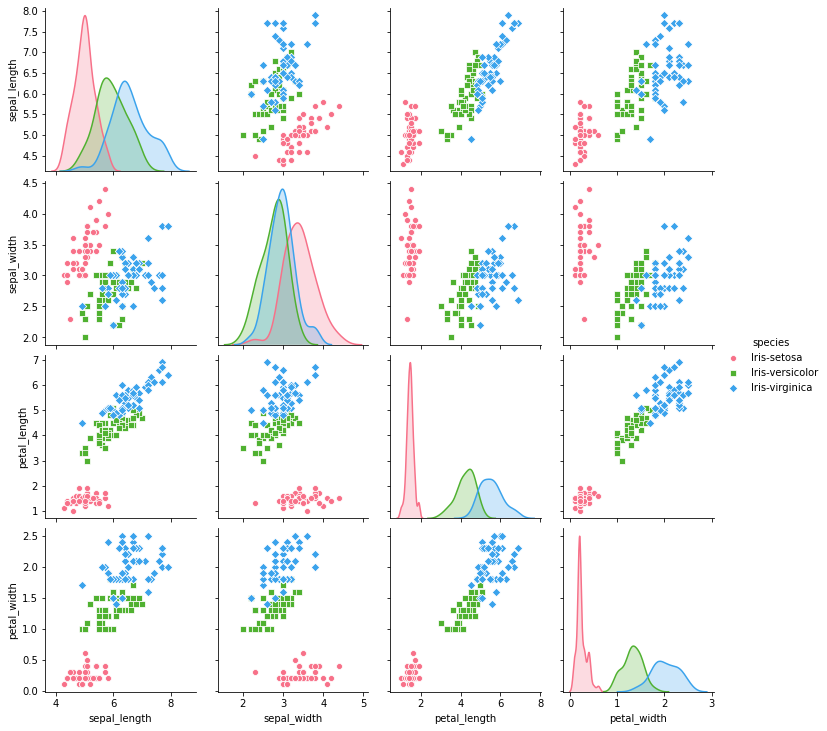

In [62]:
g = sns.pairplot(data, hue="species", palette="husl", markers=["o", "s", "D"])

Now we perform our MCMC computaiton.  With pymc3, this is very easy.  We use the usual "with" declaration for pymc3, then use glm for our logistic model and just have to specidfy the formula, the data, and the family.  The family is what tells pymc3 that this will be logistic regression.

We are going to use the default priors for GLM coefficients from PyMC3, which is $p(\theta)=N(0,10^{12}I)$.  These are very weak priors.

In [74]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'species ~ sepal_length + sepal_width + petal_length + petal_width', 
                            data = data, 
                            family = pm.glm.families.Binomial())

    trace = pm.sample(1000)

Sampling 2 chains, 126 divergences: 100%|██████████| 3000/3000 [00:42<00:00, 69.89draws/s]


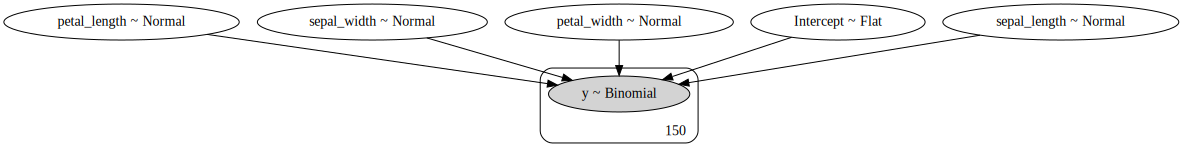

In [75]:
## I added this out of interest - I believe we discussed in class
## Defines the same logistic regression as a member of the Generalized Linear Models (GLM) family 

pm.model_to_graphviz(model)

# See: https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/

Here are the variable names in the output.  

In [76]:
trace.varnames

['Intercept', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [77]:
trace_simple = trace

In [78]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-79.922,37.675,-148.936,-20.974,2.045,1.447,340.0,340.0,346.0,662.0,1.00
sepal_length,-5.135,3.750,-11.771,1.936,0.171,0.121,483.0,481.0,500.0,696.0,1.00
sepal_width,-12.077,6.173,-23.793,-1.636,0.337,0.239,335.0,335.0,332.0,502.0,1.01
petal_length,18.824,8.047,6.793,34.132,0.451,0.319,318.0,318.0,299.0,458.0,1.00
petal_width,31.994,13.615,9.371,57.528,0.740,0.524,339.0,339.0,332.0,376.0,1.00


Here is our nice custom traceplot using the function plot_traces we defined previously.

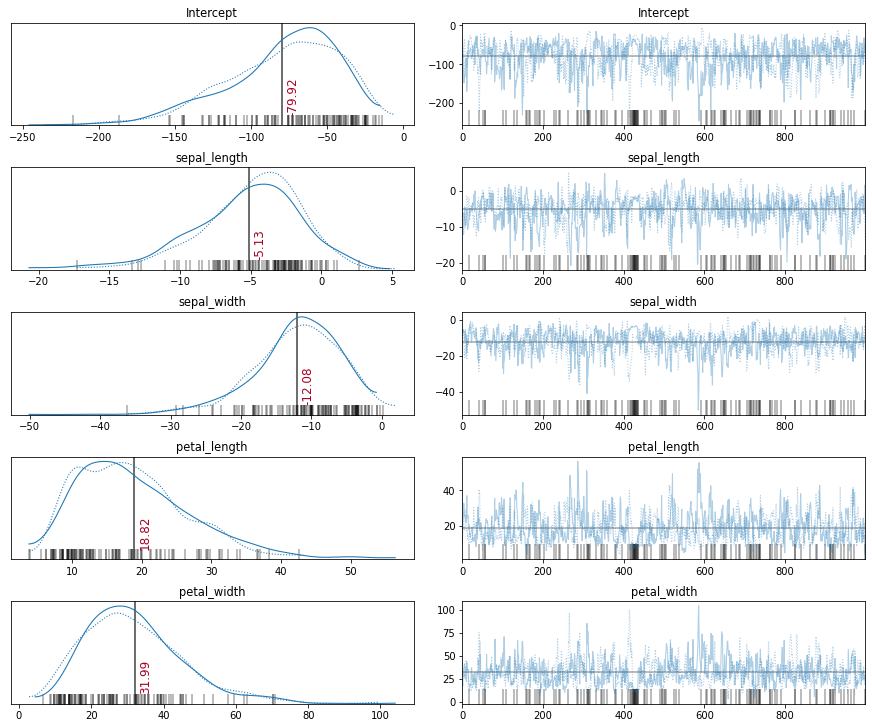

In [79]:
# PyMC3 trace is similar to an object that contains the output from MCMC sampling
plot_traces(trace)

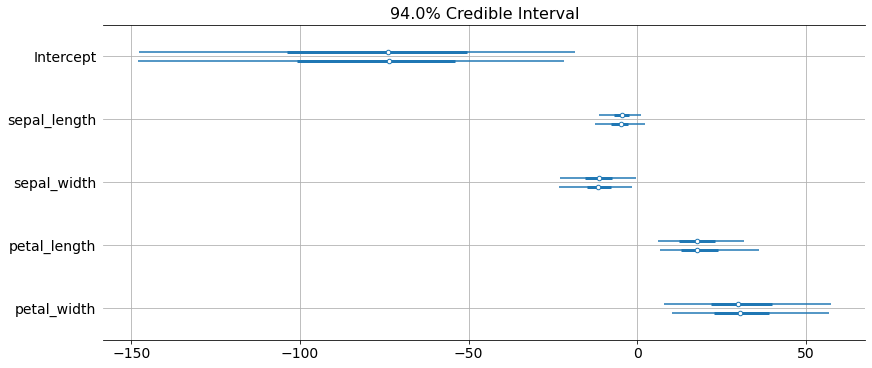

In [80]:
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
pm.plots.forestplot(trace, figsize=(12, 5))
plt.grid()  # add a grid to the plot

In [ ]:
# Seaborn joint plot which plots datapairs for easy comparison

plt.figure(figsize=(9,7))
sns.jointplot(trace['petal_length'], trace['petal_width'], kind="hex", color="#4CB391")
plt.xlabel("petal_length")
plt.ylabel("petal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['sepal_width'], kind="hex", color="#4CB391")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['petal_width'], kind="hex", color="#4CB391")
plt.xlabel("petal_length")
plt.ylabel("sepal_width");
plt.show()

plt.figure(figsize=(9,7))
sns.jointplot(trace['sepal_length'], trace['petal_length'], kind="hex", color="#4CB391")
plt.xlabel("sepal_length")
plt.ylabel("petal_width");
plt.show()

# Q1
## The results of our logistic regression model are expressed via three plots: a PyMC3 traceplot, a matplotlib forestplot, and a seaborn joint plot. In the trace plot, the predictor variables that are most likely to be zero are those with whose marginalized distribution plot (the plots on the left-hand side in the traceplot) includes zero. In this case, the sepal length and sepal width plots both include zero. Accordingly, they both have somelikelihood that coefficient could be zero. It's possible that sepal length could be slightly more likely to be zero because zero is slightly closer (visually) towards the center of the distribution that in the sepal width plot.

## A similar conclusion can be drwn from examining the credible intervals in the forest plot. Both chains in the sepal length credible interval 'touch' the zero line. In the sepal width plot, one of the two chains touches the zero line, and the othert is very close to zero and much closer than any of the other variables' chains.

## The jointplot plots two variables together. The darker hexagons in the plot indicate some relationship between the two dimensions. The darkest areas reflect the highest probabilities. Similar to the plots above, the plots that show darker hexes around or at zero have an increased probability of being zero. This can expressly be seen in the second plot (sepal length x sepal width) where colored/darker hexes are on around around zero on both axes.

### See: https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/

### Question 1 - Appendix -  I worked a little bit ahead with below.

In [ ]:
## Run Automatic Differentation Variational Inference (ADVI)
## ADVI is an alternative method to CAVI to maximize the ELBO

from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    callback = CheckParametersConvergence(diff='absolute')
    approx = pm.fit(n=1000, callbacks=[callback])
    
# See: https://luiarthur.github.io/statorial/varinf/introvi/
# See: https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/

In [ ]:
# Persist result
from pathlib import Path
import pickle
from collections import OrderedDict
with open('model_advi.pkl', 'wb') as buff:
    pickle.dump({'model': model,
                 'approx': approx}, buff)

In [ ]:
# Draw samples from the approximated distribution to obtain a trace object as above for the MCMC sampler:
trace_advi = approx.sample(200)

In [ ]:
pm.summary(trace_advi)

In [ ]:
# Visualize the covariance structure of the model
# Professor Basener - I have some questions about this

import arviz as az

az.plot_pair(trace_advi, figsize=(8, 8));

# Part 2. Logistic Regression for Predicting Coronary Heart Disease
# Base Case - Logistic Regression

Now lets apply some Bayesian Regression techniques to a healthcare problem of determining risk for Coronary Heart Disease.  Logistic Regression is a great method for this problem because it provides esitmates of probability of heart disease and the Bayesian analysis provides insight into uncertainty and importance of the different predicotr variables.

In [63]:
chd_data = pd.read_csv("../input/coronary-heart-disease/CHDdata.csv")
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [64]:
chd_data.describe()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


In [65]:
# Standardize the data (mean for each numerical variable of zero, standard deviation of one.)
for key in chd_data.keys()[0:9]:
    try:
        print("Standardizing "+key+".")
        chd_data[key] = chd_data[key] - np.mean(chd_data[key])
        chd_data[key] = chd_data[key] / np.std(chd_data[key])
    except:
        print("Predictor "+key+" cannot be standardized (probably a categorical variable).")
chd_data.describe()

Standardizing sbp.
Standardizing tobacco.
Standardizing ldl.
Standardizing adiposity.
Standardizing famhist.
Predictor famhist cannot be standardized (probably a categorical variable).
Standardizing typea.
Standardizing obesity.
Standardizing alcohol.
Standardizing age.


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,4.620000e+02,462.000000
mean,-2.571296e-16,5.022437e-16,-3.963040e-15,1.559599e-15,1.153478e-17,-5.286776e-15,-4.169344e-16,1.970526e-17,0.346320
std,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,1.001084e+00,0.476313
min,-1.823123e+00,-7.924170e-01,-1.817753e+00,-2.401708e+00,-4.089354e+00,-2.695129e+00,-6.969825e-01,-1.906103e+00,0.000000
25%,-6.997535e-01,-7.809742e-01,-7.047170e-01,-7.245926e-01,-6.224081e-01,-7.267824e-01,-6.761275e-01,-8.096968e-01,0.000000
50%,-2.113321e-01,-3.565020e-01,-1.935182e-01,9.112757e-02,-1.059418e-02,-5.680824e-02,-3.898822e-01,1.496582e-01,0.000000
75%,4.724579e-01,4.063492e-01,5.074164e-01,7.489145e-01,7.031887e-01,5.828745e-01,2.800340e-01,8.349118e-01,1.000000
max,3.891408e+00,6.007857e+00,5.119082e+00,2.197976e+00,2.538631e+00,4.878906e+00,5.321938e+00,1.451640e+00,1.000000


In [66]:
# Lets check the mean of each class to get a first look at the separation
print("Mean for CHD Positive:")
print(np.array([chd_data[chd_data.chd == 1].mean()[0:8]]))
print("Mean for CHD Negative:")
print(np.array([chd_data[chd_data.chd == 0].mean()[0:8]]))

Mean for CHD Positive:
[[0.26426823 0.41177089 0.36139839 0.34912802 0.14172199 0.13751694
  0.0859086  0.51241433]]
Mean for CHD Negative:
[[-0.14000966 -0.21815676 -0.19146935 -0.18496849 -0.0750845  -0.07285666
  -0.04551449 -0.27147779]]


In [67]:
chd_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.823073,0.478412,-0.295503,Present,-0.418470,-0.176786,3.277738,0.629336,1
1,0.277089,-0.790237,-0.159680,0.412140,Absent,0.193344,0.671373,-0.612745,1.383115,1
2,-0.992806,-0.774980,-0.609245,0.884332,Present,-0.112563,0.735519,-0.541183,0.218184,0
3,1.546985,0.842264,0.807126,1.624141,Present,-0.214532,1.412621,0.295062,1.040488,1
4,-0.211332,2.171805,-0.599577,0.305351,Present,0.703189,-0.012856,1.647775,0.423760,1


# Create Logistic Regression model with CHD dataset - with priors

In [68]:
with pm.Model() as model:
    # Define priors for intercept & regression coefficients
    # x5 is categorical predictor 'famhist' - using uninformative prior
    # Note however the source footnoted below - "there is no such thing as
    # an uninformative (beta (prior)"
    
    priors = {
        "Intercept": pm.Normal.dist(mu=0.0, sigma=1.0),
        "sbp": pm.Normal.dist(mu=0.0, sigma=1.0),
        "tobacco": pm.Normal.dist(mu=0.0, sigma=1.0),
        "ldl": pm.Normal.dist(mu=0.0, sigma=1.0),
        "adiposity": pm.Normal.dist(mu=0.0, sigma=1.0),
        "famhist": pm.Beta.dist(alpha=1.0, beta=1.0),
        "typea": pm.Normal.dist(mu=0.0, sigma=1.0),
        "obesity": pm.Normal.dist(mu=0.0, sigma=1.0),
        "alcohol": pm.Normal.dist(mu=0.0, sigma=1.0),
        "age": pm.Normal.dist(mu=0.0, sigma=1.0),
    }
    pm.glm.GLM.from_formula(formula = 'chd ~ sbp + tobacco + ldl + adiposity + famhist + typea + obesity + alcohol + age', 
                            data = chd_data, 
                            family = pm.glm.families.Normal())

    #trace = pm.sample(5000) 
    approx = pm.fit(50000, method = 'advi')
    
# See: https://stats.stackexchange.com/questions/297901/choosing-between-uninformative-beta-priors
# See: https://docs.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html?highlight=family
# See: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM-model-selection.html?highlight=family

Average Loss = 356.7: 100%|██████████| 50000/50000 [00:28<00:00, 1739.26it/s] 


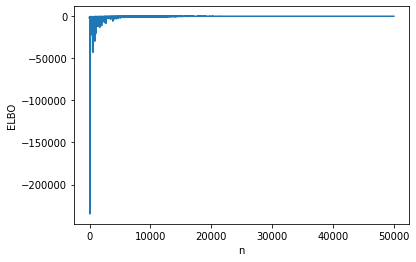

In [69]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [70]:
trace_VI = approx.sample(draws=5000)

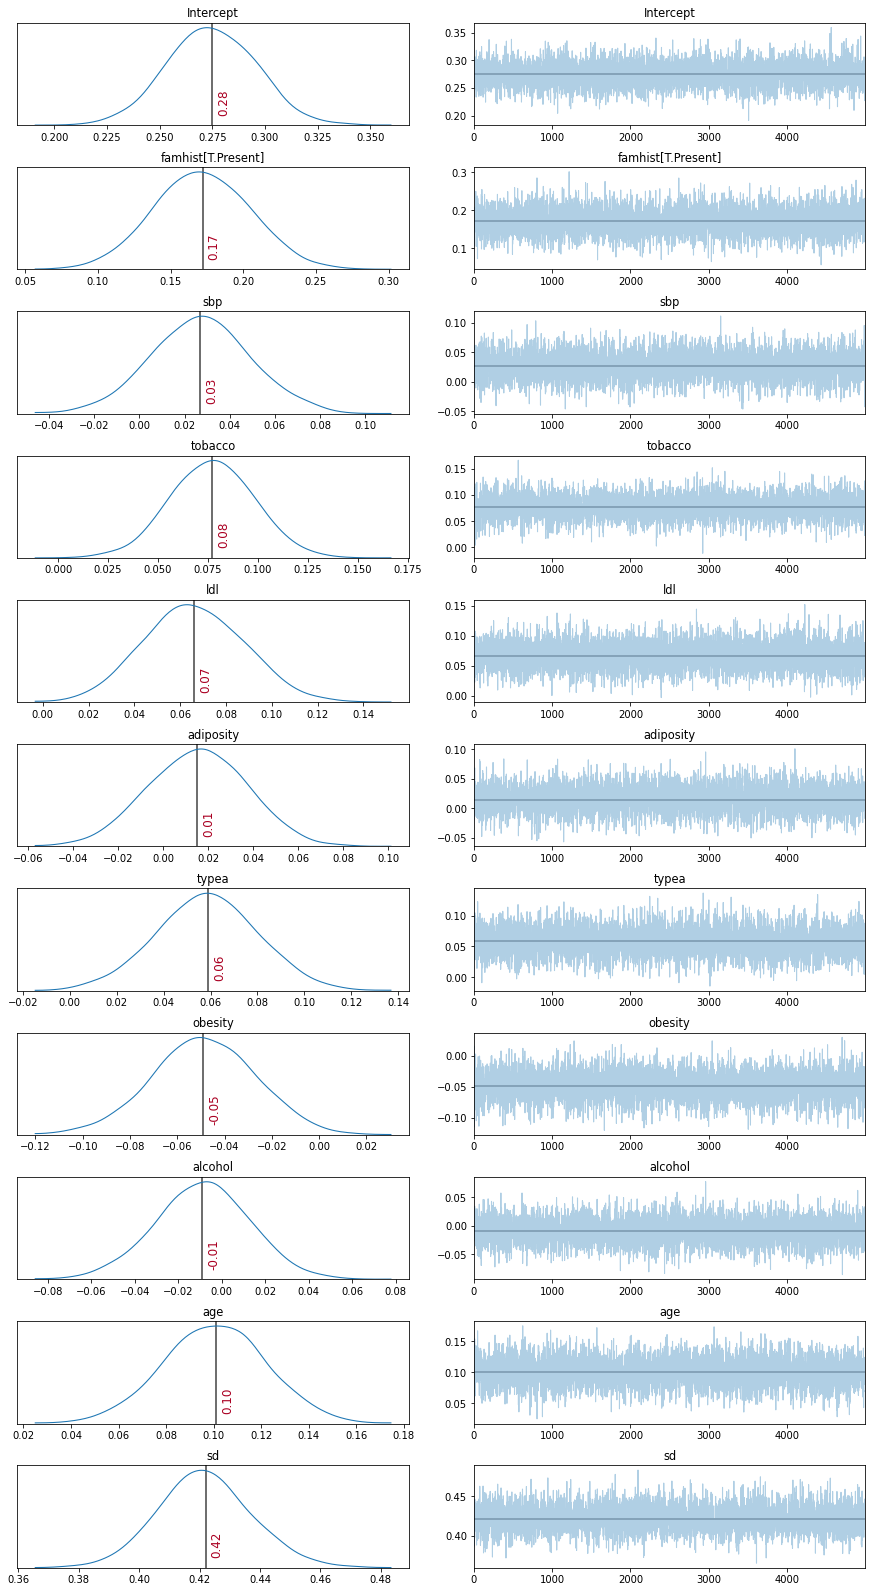

In [71]:
plot_traces(trace_VI)

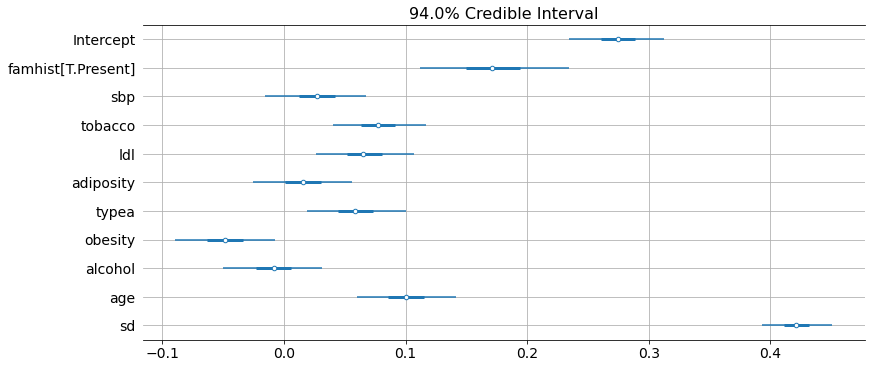

In [72]:
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
pm.plots.forestplot(trace_VI, figsize=(12, 5))
plt.grid()  # add a grid to the plot

In [73]:
pm.summary(trace_VI).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.28,0.02,0.24,0.31,0.0,0.0,5157.0,5157.0,5148.0,4778.0,NaN
famhist[T.Present],0.17,0.03,0.11,0.23,0.0,0.0,4910.0,4910.0,4911.0,4728.0,NaN
sbp,0.03,0.02,-0.02,0.07,0.0,0.0,5049.0,4982.0,5058.0,4580.0,NaN
tobacco,0.08,0.02,0.04,0.12,0.0,0.0,4944.0,4901.0,4941.0,4755.0,NaN
ldl,0.07,0.02,0.03,0.11,0.0,0.0,4905.0,4905.0,4905.0,4456.0,NaN
adiposity,0.02,0.02,-0.02,0.06,0.0,0.0,4942.0,4942.0,4945.0,5016.0,NaN
typea,0.06,0.02,0.02,0.10,0.0,0.0,5068.0,5068.0,5067.0,4900.0,NaN
obesity,-0.05,0.02,-0.09,-0.01,0.0,0.0,4492.0,4492.0,4504.0,4572.0,NaN
alcohol,-0.01,0.02,-0.05,0.03,0.0,0.0,5041.0,4858.0,5038.0,4897.0,NaN
age,0.10,0.02,0.06,0.14,0.0,0.0,4886.0,4886.0,4888.0,5068.0,NaN


# Original Logistic Regression Model - no priors

In [ ]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = 'chd ~ sbp + tobacco + ldl + adiposity + typea + obesity + alcohol + age + famhist', 
                            data = chd_data, 
                            family = pm.glm.families.Binomial())

    #trace = pm.sample(5000) 
    approx = pm.fit(50000, method = 'advi')

In [ ]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [ ]:
trace_VII = approx.sample(draws=5000)

In [ ]:
plot_traces(trace_VII)

In [ ]:
# The creates a matplotlib plot, so we can modify with standard matplotlib commands
pm.plots.forestplot(trace_VII, figsize=(12, 5))
plt.grid()  # add a grid to the plot

In [ ]:
pm.summary(trace_VII).round(2)